In [2]:
import os
import copy
import pickle
import warnings
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import bootstrap

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import palettable
import deepdish as dd
from matplotlib.ticker import NullLocator


from astropy.utils.console import ProgressBar
from astropy.table import QTable,hstack
plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 30})

/Users/xushuo/miniconda3/envs/tardis/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_dir="/Users/xushuo/work/Submit/Simulation/data/"
fig_dir="/Users/xushuo/work/Papers/Simulation/Figure/"

In [4]:
#hdf5 for run TopN test
tab0=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_mass')
tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_mass')

In [6]:
tab1

gal_num,proj,catsh_primary,mass_halo,mass_stellar_gal,mass_stellar_ins,mass_stellar_exs,aper_1reff_ins,aper_1reff_exs,aper_1reff_gal,aper_1reff_ins_force,aper_1reff_exs_force,aper_2reff_ins,aper_2reff_exs,aper_2reff_gal,aper_2reff_ins_force,aper_2reff_exs_force,aper_3reff_ins,aper_3reff_exs,aper_3reff_gal,aper_3reff_ins_force,aper_3reff_exs_force,aper_4reff_ins,aper_4reff_exs,aper_4reff_gal,aper_4reff_ins_force,aper_4reff_exs_force,aper_5reff_ins,aper_5reff_exs,aper_5reff_gal,aper_5reff_ins_force,aper_5reff_exs_force,aper_8reff_ins,aper_8reff_exs,aper_8reff_gal,aper_8reff_ins_force,aper_8reff_exs_force,aper_10reff_ins,aper_10reff_exs,aper_10reff_gal,aper_10reff_ins_force,aper_10reff_exs_force
int64,str2,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,xy,True,935112968750000.0,2313185432742.945,549864876039.7438,1763320556703.1973,274253513097.04425,784693547475.5602,1047845769916.0227,443770120344.6309,604075649571.3917,382695318663.02484,1240065247821.6943,1494488908726.934,485202359223.2652,1009286549503.6687,397642567291.9879,1555664841513.9395,1792785444565.1157,510395530508.01746,1282389914057.0986,404303019973.5969,1731578716557.9817,2039531233078.4902,529029885333.9341,1510501347744.557,409464368054.11743,1760442101047.0598,2210494011335.898,543248977869.54987,1667245033466.3481,423173024294.34955,1763320556703.1975,2313184827149.688,549864876039.7444,1763319951109.9434,431559322171.68317,1763320556703.1975,2313185432742.942,549864876039.7445,1763320556703.1975
0,yz,True,935112968750000.0,2440303566430.2744,556775179977.3944,1883528386452.8787,269338044322.26645,844299982575.0687,1123047729057.7632,451357723049.46375,671690006008.2993,382043430667.2149,1362243765006.725,1631091289087.9536,495551537640.65485,1135539751447.2988,399094169391.04193,1692946054974.5938,1979950434958.6228,523061783088.91284,1456888651869.7097,405976760096.59875,1854240120834.2854,2228100285614.5073,541568944171.4756,1686531341443.0322,411689751641.8707,1881004079575.0205,2381930591809.994,553038179311.533,1828892412498.4612,426916984992.19336,1883528386452.8782,2440303566430.273,556775179977.3944,1883528386452.8782,436428815576.46497,1883528386452.8782,2440303566430.273,556775179977.3945,1883528386452.8787
0,xz,True,935112968750000.0,2602477311365.8516,558650090107.518,2043827221258.329,283841290817.23303,948751127737.8721,1221217977075.029,454453859364.17,766764117710.859,386735269781.73486,1470999860133.012,1729087039811.9062,499076465178.84973,1230010574633.0562,400888024807.1035,1800740972888.226,2087737298911.3462,525975795013.9993,1561761503897.347,407796690226.7623,1995390346080.2224,2336465553669.0103,543819020973.1848,1792646532695.8257,413317968113.31934,2042087986375.857,2516327219128.9473,555359554651.5554,1960967664477.392,430181131082.85614,2043827221258.3325,2602477311365.8496,558650090107.5175,2043827221258.3328,440612498076.53796,2043827221258.3325,2602477311365.8496,558650090107.5175,2043827221258.3325
1,xy,True,624025585937500.0,2657599369334.1436,354373708374.9374,2303225660959.2065,171834813525.7151,953552523542.6912,1098621525264.4158,302503620215.36444,796117905049.0511,223030157659.98096,1644325687116.2346,1794771308365.1204,326179186542.71747,1468592121822.4028,241797581448.7072,2044623034651.0996,2188290334999.4778,337459777826.37445,1850830557173.1033,253588383483.01593,2277241602614.96,2494924733232.6753,347136251301.56396,2147788481931.1113,262754471478.58527,2300600767114.7305,2639635878141.839,353563675793.84625,2286072202347.992,285429856583.25183,2303225660959.2065,2657599369334.144,354373708374.9374,2303225660959.2065,295894947709.0359,2303225660959.2065,2657599369334.144,354373708374.9373,2303225660959.2065
1,yz,True,624025585937500.0,26823119

In [4]:
sma_list=np.asarray([30,50,75,100,150])
sma_list0=np.asarray([1,2,3,4,5,8,10])

In [5]:
def mpeakfind(tab,bin_num=30):
    numb,bins=np.histogram(tab,bins=bin_num)
    max_value=max(numb)
    max_index=list(numb).index(max_value)
    mpeak=bins[max_index]
    return mpeak

In [15]:
def mockdata(tab,name,sigma_aper=0.1):
    err=np.random.lognormal(sigma=sigma_aper,size=len(tab))
    mock_gal_num=tab[tab.colnames[0]]
    mock_proj=tab[tab.colnames[1]]
    mock_catsh_primary=tab[tab.colnames[2]]
    mock_mass_halo=tab[tab.colnames[3]]
    mock_stellar=tab[name]*err
    table=QTable([mock_gal_num,mock_proj,mock_catsh_primary,mock_mass_halo,mock_stellar],names=('gal_num','proj','catsh_primary','mass_halo','stellar'))
    return table

In [14]:
def mockoutdata(tab,name1,name2,sigma_out=0.15):
    err=np.random.lognormal(sigma=sigma_out,size=len(tab))
    mock_gal_num=tab[tab.colnames[0]]
    mock_proj=tab[tab.colnames[1]]
    mock_catsh_primary=tab[tab.colnames[2]]
    mock_mass_halo=tab[tab.colnames[3]]
    mock_stellar=(tab[name1]-tab[name2])*err
    table=QTable([mock_gal_num,mock_proj,mock_catsh_primary,mock_mass_halo,mock_stellar],names=('gal_num','proj','catsh_primary','mass_halo','stellar'))
    return table

In [43]:
def topNselect(data,name,number):
    data_meta=data.group_by(name)
    data0=data_meta[-number::]
    return data0
def medNselect(data,name,numb1,numb2):
    data_meta=data.group_by(name)
    if numb1!=0:
        data0=data_meta[-numb2:-numb1:]
    else:
        data0=data_meta[-numb2::]
    return data0
def mocktopNscatter(data,name,number):
    scatter=[]
    for i in range(2000):
        data_mock=mockdata(data,name)
        topN=topNselect(data_mock,'stellar',number)
        scatter.append(np.std(np.log10(topN['mass_halo']),ddof=1))
    print(name)
    mean=np.mean(scatter)
    sca=np.std(scatter,ddof=1)
    return mean,sca
def mockmedNscatter(data,name,numb1,numb2):
    scatter=[]
    for i in range(2000):
        data_mock=mockdata(data,name)
        medN=medNselect(data_mock,'stellar',numb1,numb2)
        scatter.append(np.std(np.log10(medN['mass_halo']),ddof=1))
    print(name)
    mean=np.mean(scatter)
    sca=np.std(scatter,ddof=1)
    return mean,sca
def mocktopNoutscatter(data,name1,name2,number):
    scatter=[]
    for i in range(2000):
        data_mock=mockoutdata(data,name1,name2)
        topN=topNselect(data_mock,'stellar',number)
        scatter.append(np.std(np.log10(topN['mass_halo']),ddof=1))
    print(name1)
    mean=np.mean(scatter)
    sca=np.std(scatter,ddof=1)
    return mean,sca
def mockmedNoutscatter(data,name1,name2,numb1,numb2):
    scatter=[]
    for i in range(2000):
        data_mock=mockoutdata(data,name1,name2)
        medN=medNselect(data_mock,'stellar',numb1,numb2)
        scatter.append(np.std(np.log10(medN['mass_halo']),ddof=1))
    print(name1)
    mean=np.mean(scatter)
    sca=np.std(scatter,ddof=1)
    return mean,sca


In [56]:
numb_list1=np.asarray([50,100,200,500,1000,1500])
numb_list2=np.asarray([50,180,350,700,1200])

In [37]:
numb_list=numb_list1
mask0=(tab0['catsh_primary']==True)&(tab0['proj']=='xy')&(tab0["mass_stellar_ins"]>1e10)&(tab0["mass_stellar_exs"]>10**10.5)
name_tab=[]
tab=tab0[mask0]
for i in range(len(numb_list)):
    exec('tng300_'+str(numb_list[i])+'_scatter_mean=[]')
    exec('tng300_'+str(numb_list[i])+'_scatter_err=[]')
for i in sma_list:
    for map_type in ('ins','exs','gal'):
        exec('name="aper_'+str(i)+'_'+map_type+'"')
        name_tab.append('aper_'+str(i)+'_'+map_type)
        mpeak=mpeakfind(np.log10(tab['aper_'+str(i)+'_'+map_type]))
        mask=(tab['aper_'+str(i)+'_'+map_type]>10**mpeak)
        for j in range(len(numb_list)):
            mean,err=mocktopNscatter(tab[mask],name,numb_list[j])
            exec('tng300_'+str(numb_list[j])+'_scatter_mean.append(mean)')
            exec('tng300_'+str(numb_list[j])+'_scatter_err.append(err)')
for i in sma_list[:-2:]:
    for map_type in ('ins','exs','gal'):
        exec('name1="aper_100_'+map_type+'"')
        exec('name2="aper_'+str(i)+'_'+map_type+'"')
        name_tab.append('out_'+str(i)+'_100_'+map_type)
        mpeak=mpeakfind(np.log10(tab['aper_100_'+map_type]-tab['aper_'+str(i)+'_'+map_type]))
        mask=(tab['aper_100_'+map_type]-tab['aper_'+str(i)+'_'+map_type]>10**mpeak)
        for j in range(len(numb_list)):
            mean,err=mocktopNoutscatter(tab[mask],name1,name2,numb_list[j])
            exec('tng300_'+str(numb_list[j])+'_scatter_mean.append(mean)')
            exec('tng300_'+str(numb_list[j])+'_scatter_err.append(err)')
for map_type in ('ins','exs','gal'):
    exec('name="mass_stellar_'+map_type+'"')
    name_tab.append('mass_stellar_'+map_type)
    mpeak=mpeakfind(np.log10(tab[name]))
    mask=(tab[name]>10**mpeak)
    for j in range(len(numb_list)):
        mean,err=mocktopNscatter(tab[mask],name,numb_list[j])
        exec('tng300_'+str(numb_list[j])+'_scatter_mean.append(mean)')
        exec('tng300_'+str(numb_list[j])+'_scatter_err.append(err)')
mask1=(tab1['catsh_primary']==True)&(tab1['proj']=='xy')&(tab1["mass_stellar_ins"]>1e10)&(tab1["mass_stellar_exs"]>10**10.5)
tab=tab1[mask1]
for i in sma_list0:
    for map_type in ('ins','exs','gal','ins_force','exs_force'):
        exec('name="aper_'+str(i)+'reff_'+map_type+'"')
        name_tab.append('aper_'+str(i)+'reff_'+map_type)
        mpeak=mpeakfind(np.log10(tab['aper_'+str(i)+'reff_'+map_type]))
        mask=(tab['aper_'+str(i)+'reff_'+map_type]>10**mpeak)
        for j in range(len(numb_list)):
            mean,err=mocktopNscatter(tab[mask],name,numb_list[j])
            exec('tng300_'+str(numb_list[j])+'_scatter_mean.append(mean)')
            exec('tng300_'+str(numb_list[j])+'_scatter_err.append(err)')
for i in sma_list0[:-2:]:
    for map_type in ('ins','exs','gal','ins_force','exs_force'):
        exec('name1="aper_8reff_'+map_type+'"')
        exec('name2="aper_'+str(i)+'reff_'+map_type+'"')
        name_tab.append('out_'+str(i)+'_8reff_'+map_type)
        mask0=(tab['aper_8reff_'+map_type]-tab['aper_'+str(i)+'reff_'+map_type])>0
        mpeak=mpeakfind(np.log10(tab[mask0]['aper_8reff_'+map_type]-tab[mask0]['aper_'+str(i)+'reff_'+map_type]))
        mask=(tab['aper_8reff_'+map_type]-tab['aper_'+str(i)+'reff_'+map_type]>10**mpeak)
        for j in range(len(numb_list)):
            mean,err=mocktopNoutscatter(tab[mask],name1,name2,numb_list[j])
            exec('tng300_'+str(numb_list[j])+'_scatter_mean.append(mean)')
            exec('tng300_'+str(numb_list[j])+'_scatter_err.append(err)')

aper_30_ins
aper_30_ins
aper_30_ins
aper_30_ins
aper_30_ins
aper_30_ins
aper_30_exs
aper_30_exs
aper_30_exs
aper_30_exs
aper_30_exs
aper_30_exs
aper_30_gal
aper_30_gal
aper_30_gal
aper_30_gal
aper_30_gal
aper_30_gal
aper_50_ins
aper_50_ins
aper_50_ins
aper_50_ins
aper_50_ins
aper_50_ins
aper_50_exs
aper_50_exs
aper_50_exs
aper_50_exs
aper_50_exs
aper_50_exs
aper_50_gal
aper_50_gal
aper_50_gal
aper_50_gal
aper_50_gal
aper_50_gal
aper_75_ins
aper_75_ins
aper_75_ins
aper_75_ins
aper_75_ins
aper_75_ins
aper_75_exs
aper_75_exs
aper_75_exs
aper_75_exs
aper_75_exs
aper_75_exs
aper_75_gal
aper_75_gal
aper_75_gal
aper_75_gal
aper_75_gal
aper_75_gal
aper_100_ins
aper_100_ins
aper_100_ins
aper_100_ins
aper_100_ins
aper_100_ins
aper_100_exs
aper_100_exs
aper_100_exs
aper_100_exs
aper_100_exs
aper_100_exs
aper_100_gal
aper_100_gal
aper_100_gal
aper_100_gal
aper_100_gal
aper_100_gal
aper_150_ins
aper_150_ins
aper_150_ins
aper_150_ins
aper_150_ins
aper_150_ins
aper_150_exs
aper_150_exs
aper_150_exs
a

aper_8reff_ins_force
aper_8reff_ins_force
aper_8reff_ins_force
aper_8reff_ins_force
aper_8reff_exs_force
aper_8reff_exs_force
aper_8reff_exs_force
aper_8reff_exs_force
aper_8reff_exs_force
aper_8reff_exs_force


In [31]:
name_tab

['aper_30_ins',
 'aper_30_exs',
 'aper_30_gal',
 'aper_50_ins',
 'aper_50_exs',
 'aper_50_gal',
 'aper_75_ins',
 'aper_75_exs',
 'aper_75_gal',
 'aper_100_ins',
 'aper_100_exs',
 'aper_100_gal',
 'aper_150_ins',
 'aper_150_exs',
 'aper_150_gal',
 'out_30_100_ins',
 'out_30_100_exs',
 'out_30_100_gal',
 'out_50_100_ins',
 'out_50_100_exs',
 'out_50_100_gal',
 'out_75_100_ins',
 'out_75_100_exs',
 'out_75_100_gal',
 'mass_stellar_ins',
 'mass_stellar_exs',
 'mass_stellar_gal',
 'aper_1reff_ins',
 'aper_1reff_exs',
 'aper_1reff_gal',
 'aper_1reff_ins_force',
 'aper_1reff_exs_force',
 'aper_2reff_ins',
 'aper_2reff_exs',
 'aper_2reff_gal',
 'aper_2reff_ins_force',
 'aper_2reff_exs_force',
 'aper_3reff_ins',
 'aper_3reff_exs',
 'aper_3reff_gal',
 'aper_3reff_ins_force',
 'aper_3reff_exs_force',
 'aper_4reff_ins',
 'aper_4reff_exs',
 'aper_4reff_gal',
 'aper_4reff_ins_force',
 'aper_4reff_exs_force',
 'aper_5reff_ins',
 'aper_5reff_exs',
 'aper_5reff_gal',
 'aper_5reff_ins_force',
 'aper_5re

In [38]:
str0=','
str1=','
for i in range(len(numb_list)):
    str0=str0+'tng300_'+str(numb_list[i])+'_scatter_mean,'+'tng300_'+str(numb_list[i])+'_scatter_err,'
    str1=str1+'"tng300_'+str(numb_list[i])+'_scatter_mean",'+'"tng300_'+str(numb_list[i])+'_scatter_err",'

In [39]:
exec('topN_tab1=QTable([name_tab'+str0[:-1:]+'],names=("item"'+str1[:-1:]+'))')

In [61]:
numb_list=numb_list2
mask0=(tab0['catsh_primary']==True)&(tab0['proj']=='xy')&(tab0["mass_stellar_ins"]>1e10)&(tab0["mass_stellar_exs"]>10**10.5)
name_tab=[]
tab=tab0[mask0]
for i in range(len(numb_list)-1):
    exec('tng300_'+str(numb_list[i])+'_'+str(numb_list[i+1])+'_scatter_mean=[]')
    exec('tng300_'+str(numb_list[i])+'_'+str(numb_list[i+1])+'_scatter_err=[]')
for i in sma_list:
    for map_type in ('ins','exs','gal'):
        exec('name="aper_'+str(i)+'_'+map_type+'"')
        name_tab.append('aper_'+str(i)+'_'+map_type)
        mpeak=mpeakfind(np.log10(tab['aper_'+str(i)+'_'+map_type]))
        mask=(tab['aper_'+str(i)+'_'+map_type]>10**mpeak)
        for j in range(len(numb_list)-1):
            mean,err=mockmedNscatter(tab[mask],name,numb_list[j],numb_list[j+1])
            print(mean)
            exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_mean.append(mean)')
            exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_err.append(err)')
for i in sma_list[:-2:]:
    for map_type in ('ins','exs','gal'):
        exec('name1="aper_100_'+map_type+'"')
        exec('name2="aper_'+str(i)+'_'+map_type+'"')
        name_tab.append('out_'+str(i)+'_100_'+map_type)
        mpeak=mpeakfind(np.log10(tab['aper_100_'+map_type]-tab['aper_'+str(i)+'_'+map_type]))
        mask=(tab['aper_100_'+map_type]-tab['aper_'+str(i)+'_'+map_type]>10**mpeak)
        for j in range(len(numb_list)-1):
            mean,err=mockmedNoutscatter(tab[mask],name1,name2,numb_list[j],numb_list[j+1])
            exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_mean.append(mean)')
            exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_err.append(err)')
for map_type in ('ins','exs','gal'):
    exec('name="mass_stellar_'+map_type+'"')
    name_tab.append('mass_stellar_'+map_type)
    mpeak=mpeakfind(np.log10(tab[name]))
    mask=(tab[name]>10**mpeak)
    for j in range(len(numb_list)-1):
        mean,err=mockmedNscatter(tab[mask],name,numb_list[j],numb_list[j+1])
        exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_mean.append(mean)')
        exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_err.append(err)')
mask1=(tab1['catsh_primary']==True)&(tab1['proj']=='xy')&(tab1["mass_stellar_ins"]>1e10)&(tab1["mass_stellar_exs"]>10**10.5)
tab=tab1[mask1]
for i in sma_list0:
    for map_type in ('ins','exs','gal','ins_force','exs_force'):
        exec('name="aper_'+str(i)+'reff_'+map_type+'"')
        name_tab.append('aper_'+str(i)+'reff_'+map_type)
        mpeak=mpeakfind(np.log10(tab['aper_'+str(i)+'reff_'+map_type]))
        mask=(tab['aper_'+str(i)+'reff_'+map_type]>10**mpeak)
        for j in range(len(numb_list)-1):
            mean,err=mockmedNscatter(tab[mask],name,numb_list[j],numb_list[j+1])
            exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_mean.append(mean)')
            exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_err.append(err)')
for i in sma_list0[:-2:]:
    for map_type in ('ins','exs','gal','ins_force','exs_force'):
        exec('name1="aper_8reff_'+map_type+'"')
        exec('name2="aper_'+str(i)+'reff_'+map_type+'"')
        name_tab.append('out_'+str(i)+'_8reff_'+map_type)
        mask0=(tab['aper_8reff_'+map_type]-tab['aper_'+str(i)+'reff_'+map_type])>0
        mpeak=mpeakfind(np.log10(tab[mask0]['aper_8reff_'+map_type]-tab[mask0]['aper_'+str(i)+'reff_'+map_type]))
        mask=(tab['aper_8reff_'+map_type]-tab['aper_'+str(i)+'reff_'+map_type]>10**mpeak)
        for j in range(len(numb_list)-1):
            mean,err=mockmedNoutscatter(tab[mask],name1,name2,numb_list[j],numb_list[j+1])
            exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_mean.append(mean)')
            exec('tng300_'+str(numb_list[j])+'_'+str(numb_list[j+1])+'_scatter_err.append(err)')

aper_30_ins
0.36847035689374474
aper_30_ins
0.37285553783724945
aper_30_ins
0.3480470059570025
aper_30_ins
0.3217115059871039
aper_30_exs
0.24715830258485513
aper_30_exs
0.2572445183342894
aper_30_exs
0.2587014344006815
aper_30_exs
0.2589173191587644
aper_30_gal
0.24662904794322188
aper_30_gal
0.23626581255057957
aper_30_gal
0.2452868678706201
aper_30_gal
0.24198702914820688
aper_50_ins
0.3586262628243073
aper_50_ins
0.3526425789777389
aper_50_ins
0.3473839102814854
aper_50_ins
0.3143320419677924
aper_50_exs
0.2312892847200072
aper_50_exs
0.24534254841790903
aper_50_exs
0.23818304647933705
aper_50_exs
0.2434377365493322
aper_50_gal
0.22912298440306259
aper_50_gal
0.21782459826795766
aper_50_gal
0.2277603607343751
aper_50_gal
0.2279001431195779
aper_75_ins
0.34880502614966546
aper_75_ins
0.33575585259205076
aper_75_ins
0.34310537456765505
aper_75_ins
0.30729019140480146
aper_75_exs
0.22407913538056118
aper_75_exs
0.23157986992213755
aper_75_exs
0.2272436382824832
aper_75_exs
0.230656815

In [62]:
str0=','
str1=','
for i in range(len(numb_list)-1):
    str0=str0+'tng300_'+str(numb_list[i])+'_'+str(numb_list[i+1])+'_scatter_mean,'+'tng300_'+str(numb_list[i])+'_'+str(numb_list[i+1])+'_scatter_err,'
    str1=str1+'"tng300_'+str(numb_list[i])+'_'+str(numb_list[i+1])+'_scatter_mean",'+'"tng300_'+str(numb_list[i])+'_'+str(numb_list[i+1])+'_scatter_err",'

In [63]:
exec('topN_tab2=QTable([name_tab'+str0[:-1:]+'],names=("item"'+str1[:-1:]+'))')

In [7]:
with open(data_dir+"galaxies_tng300_072_mock_topN_final.txt",'rb') as f: 
    topN_tab1=pickle.load(f)
with open(data_dir+"galaxies_tng300_072_mock_topN_final_2.txt",'rb') as f: 
    topN_tab2=pickle.load(f)

In [8]:
topN_tab1

item,tng300_50_scatter_mean,tng300_50_scatter_err,tng300_100_scatter_mean,tng300_100_scatter_err,tng300_200_scatter_mean,tng300_200_scatter_err,tng300_500_scatter_mean,tng300_500_scatter_err,tng300_1000_scatter_mean,tng300_1000_scatter_err,tng300_1500_scatter_mean,tng300_1500_scatter_err
str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
aper_30_ins,0.4006616725471388,0.018584174796578274,0.3949066742722655,0.009656018135600526,0.3975227887634314,0.007940304650013214,0.41485308318812303,0.0037261992288821857,0.4015301398248279,0.0020645304939909278,0.3885188944058546,0.0014949916626471604
aper_30_exs,0.3031559588014702,0.009665242561807355,0.30300419627605774,0.0056867813589357415,0.2980655061096569,0.005280131109181806,0.32894774892440126,0.0033055075906415596,0.353312672126802,0.0021994622788063124,0.36393779270770416,0.001206412466928686
aper_30_gal,0.2845583545261093,0.011300014703185046,0.2970842103054382,0.006646692605150024,0.2957568593560421,0.004945723695399774,0.3167613500348947,0.003328220553162077,0.340575812554302,0.0023506670547446323,0.35776204910993986,0.00177847764887521
aper_50_ins,0.3812621675076397,0.019056753228930353,0.38620190240915725,0.010166520485016418,0.38469720620878456,0.00810585594049822,0.4045910431790062,0.004194276230851798,0.40037460800695635,0.002155846910356012,0.38717811575687083,0.0013871917044155754
aper_50_exs,0.2948866437844474,0.009704050062315636,0.293949494453479,0.0057215583925434325,0.2893137255634816,0.004696670738137701,0.3175770466325975,0.0028848516385572925,0.34183199145858384,0.0020377947212935855,0.3557181016704594,0.0010622713446214352
aper_50_gal,0.27906973811161434,0.010779696787240603,0.289425312698838,0.006319965110397107,0.2837360390316481,0.003834030148439949,0.3074950023337909,0.0031965463154856443,0.33124886557475397,0.0021065890397775236,0.35126130854983695,0.0017014363303678283
...,...,...,...,...,...,...,...,...,...,...,...,...
out_4_8reff_ins_force,0.2860520605791478,0.025195272139527453,0.3118465184286772,0.013679761637648802,0.333826358268022,0.011349648559143574,0.3910586788854422,0.005626446363069832,0.39890131201992507,0.002768696147005429,0.39119686880910126,9.546431261191327e-17
out_4_8reff_exs_force,0.2729056857867625,0.012620066037837411,0.28373013400752145,0.006682518866622758,0.27653935256410533,0.004813015108512989,0.2957403069824914,0.002847003965791282,0.3168718419781923,0.0018607677021923723,0.3348665480936562,0.0014711491239995233


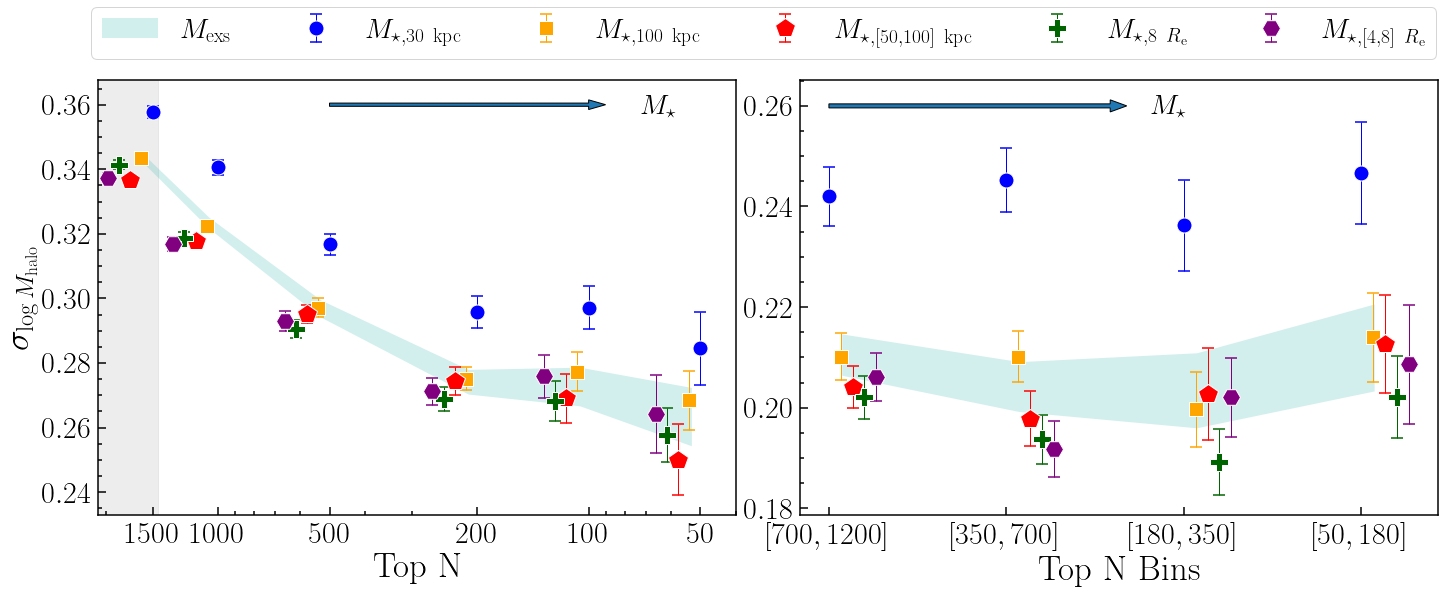

In [11]:
numb_list=np.asarray([50,100,200,500,1000,1500])
numb_list2=np.asarray([800,400,200,100])
numblist=[r'$50$',r'$100$',r'$200$',r'$500$',r'$1000$',r'$1500$']
color_list=['blue','orange','red','darkgreen','purple']
numblist2=[r'$[50,180]$',r'$[180,350]$',r'$[350,700]$',r'$[700,1200]$']
namelist=['aper_30_gal','aper_100_gal','out_50_100_gal','aper_8reff_gal','out_4_8reff_gal']
labellist=[r'$M_{\star,30{\rm\ kpc}}$',r'$M_{\star,100{\rm\ kpc}}$',r'$M_{\star,[50,100]{\rm\ kpc}}$',r'$M_{\star,8\ R_{\rm e}}$',r'$M_{\star,[4,8]\ R_{\rm e}}$']
markerlist=['o','s','p','P','H','X','D','v','*','8','>']
sizelist=np.asarray([10,9,14,12,12,9,9,9,9,9,9])*1.5
fig=plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1,2, hspace=0, wspace=0.1)
(ax1,ax2)= gs.subplots(sharex='col')
ax1.axvspan(1450,2100,color='darkgrey',alpha=0.2)
for i in range(len(namelist)):
    col=color_list[i]
    ax1.errorbar(numb_list*2**(i/10),np.asarray(list(topN_tab1[topN_tab1['item']==namelist[i]][0])[1::2]),yerr=np.asarray(list(topN_tab1[topN_tab1['item']==namelist[i]][0])[2::2]),alpha=1,fmt=markerlist[i],markersize=sizelist[i],
                 capsize=6, capthick=1.5,elinewidth=1,c=col,mec='white',label=labellist[i])
    ax2.errorbar(numb_list2*2**(i/15),np.asarray(list(topN_tab2[topN_tab2['item']==namelist[i]][0])[1::2]),yerr=np.asarray(list(topN_tab2[topN_tab2['item']==namelist[i]][0])[2::2]),alpha=1,fmt=markerlist[i],markersize=sizelist[i],
                 capsize=6, capthick=1.5,elinewidth=1,c=col,mec='white',label=labellist[i])
name='mass_stellar_exs'
err=np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[2::2])
ax1.fill_between(numb_list*2**(1.5/20),np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[1::2])+err,np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[1::2])-err,alpha=0.2,color='lightseagreen',label=r'$M_{\rm exs}$',edgecolor=None)
err=np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[2::2])
ax2.fill_between(numb_list2*2**(1.5/20),np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[1::2])+err,np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[1::2])-err,alpha=0.2,color='lightseagreen',label=r'$M_{\rm exs}$',edgecolor=None)
ax1.set_xlabel(r'\rm Top N',fontsize=35)
ax2.set_xlabel(r'\rm Top N Bins',fontsize=35)
ax1.set_ylabel(r'$\sigma_{\log{M_{\rm halo}}}$',fontsize=35)

ax1.set_xlim(40,2100)
ax1.invert_xaxis()
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xticks(numb_list,numblist)
ax2.set_xticks(numb_list2,numblist2)

ax2.xaxis.set_minor_locator(NullLocator())

ax1.legend(fontsize=28,ncol=6,bbox_to_anchor =(2.12, 1.2))
ax1.arrow(500,0.36,-400,0,head_length=10,width=0.001)
ax1.text(0.85,0.92,r'$M_\star$',transform=ax1.transAxes, size=28)
ax2.text(0.55,0.92,r'$M_\star$',transform=ax2.transAxes, size=28)
ax2.arrow(100,0.26,200,0,head_length=20,width=0.0008)
plt.savefig(fig_dir+'Fig5.png',dpi=200)

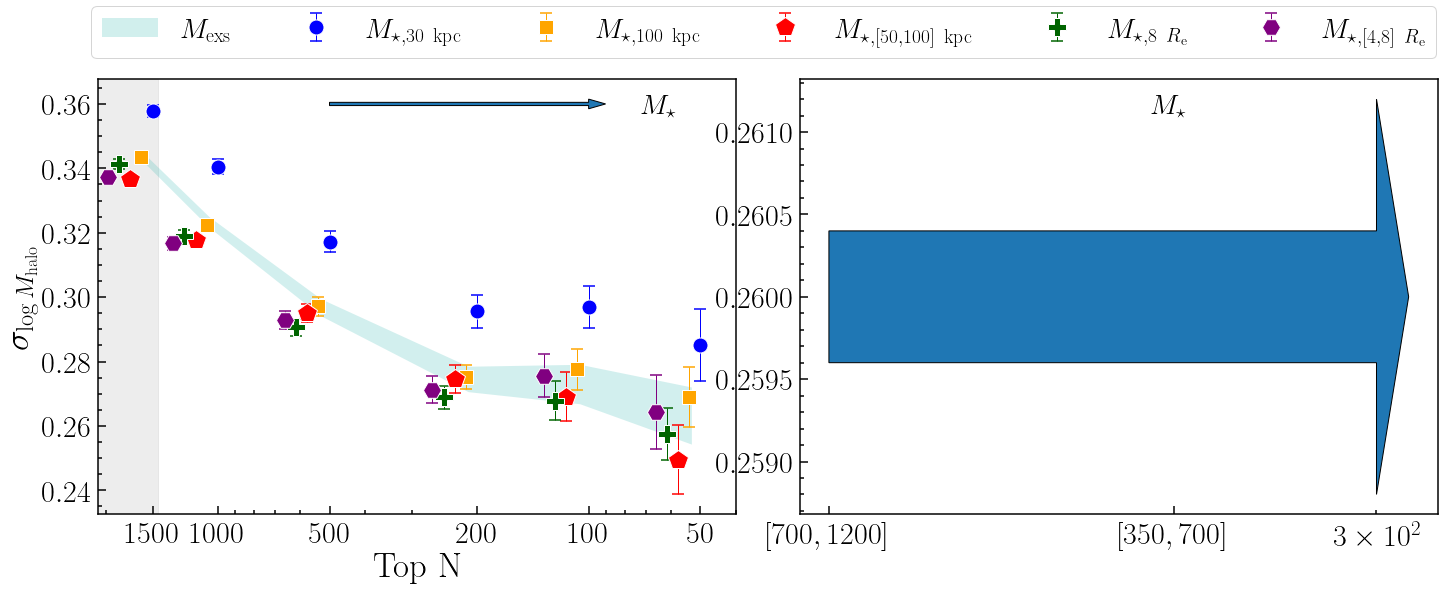

In [35]:
numb_list=np.asarray([50,100,200,500,1000,1500])
numb_list2=np.asarray([800,400,200,100])
numblist=[r'$50$',r'$100$',r'$200$',r'$500$',r'$1000$',r'$1500$']
color_list=['blue','orange','red','darkgreen','purple']
numblist2=[r'$[50,180]$',r'$[180,350]$',r'$[350,700]$',r'$[700,1200]$']
namelist=['aper_30_gal','aper_100_gal','out_50_100_gal','aper_8reff_gal','out_4_8reff_gal']
labellist=[r'$M_{\star,30{\rm\ kpc}}$',r'$M_{\star,100{\rm\ kpc}}$',r'$M_{\star,[50,100]{\rm\ kpc}}$',r'$M_{\star,8\ R_{\rm e}}$',r'$M_{\star,[4,8]\ R_{\rm e}}$']
markerlist=['o','s','p','P','H','X','D','v','*','8','>']
sizelist=np.asarray([10,9,14,12,12,9,9,9,9,9,9])*1.5
fig=plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1,2, hspace=0, wspace=0.1)
(ax1,ax2)= gs.subplots(sharex='col')
ax1.axvspan(1450,2100,color='darkgrey',alpha=0.2)
for i in range(len(namelist)):
    col=color_list[i]
    ax1.errorbar(numb_list*2**(i/10),np.asarray(list(topN_tab1[topN_tab1['item']==namelist[i]][0])[1::2]),yerr=np.asarray(list(topN_tab1[topN_tab1['item']==namelist[i]][0])[2::2]),alpha=1,fmt=markerlist[i],markersize=sizelist[i],
                 capsize=6, capthick=1.5,elinewidth=1,c=col,mec='white',label=labellist[i])
#     ax2.errorbar(numb_list2*2**(i/15),np.asarray(list(topN_tab2[topN_tab2['item']==namelist[i]][0])[1::2]),yerr=np.asarray(list(topN_tab2[topN_tab2['item']==namelist[i]][0])[2::2]),alpha=1,fmt=markerlist[i],markersize=sizelist[i],
#                  capsize=6, capthick=1.5,elinewidth=1,c=col,mec='white',label=labellist[i])
name='mass_stellar_exs'
err=np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[2::2])
ax1.fill_between(numb_list*2**(1.5/20),np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[1::2])+err,np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[1::2])-err,alpha=0.2,color='lightseagreen',label=r'$M_{\rm exs}$',edgecolor=None)
# err=np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[2::2])
# ax2.fill_between(numb_list2*2**(1.5/20),np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[1::2])+err,np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[1::2])-err,alpha=0.2,color='lightseagreen',label=r'$M_{\rm exs}$',edgecolor=None)
ax1.set_xlabel(r'\rm Top N',fontsize=35)
# ax2.set_xlabel(r'\rm Top N Bins',fontsize=35)
ax1.set_ylabel(r'$\sigma_{\log{M_{\rm halo}}}$',fontsize=35)

ax1.set_xlim(40,2100)
ax1.invert_xaxis()
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xticks(numb_list,numblist)
ax2.set_xticks(numb_list2,numblist2)

ax1.legend(fontsize=28,ncol=6,bbox_to_anchor =(2.12, 1.2))
ax1.arrow(500,0.36,-400,0,head_length=10,width=0.001)
ax1.text(0.85,0.92,r'$M_\star$',transform=ax1.transAxes, size=28)
ax2.text(0.55,0.92,r'$M_\star$',transform=ax2.transAxes, size=28)
ax2.arrow(100,0.26,200,0,head_length=20,width=0.0008)
#plt.savefig(fig_dir+'Fig5.png',dpi=200)

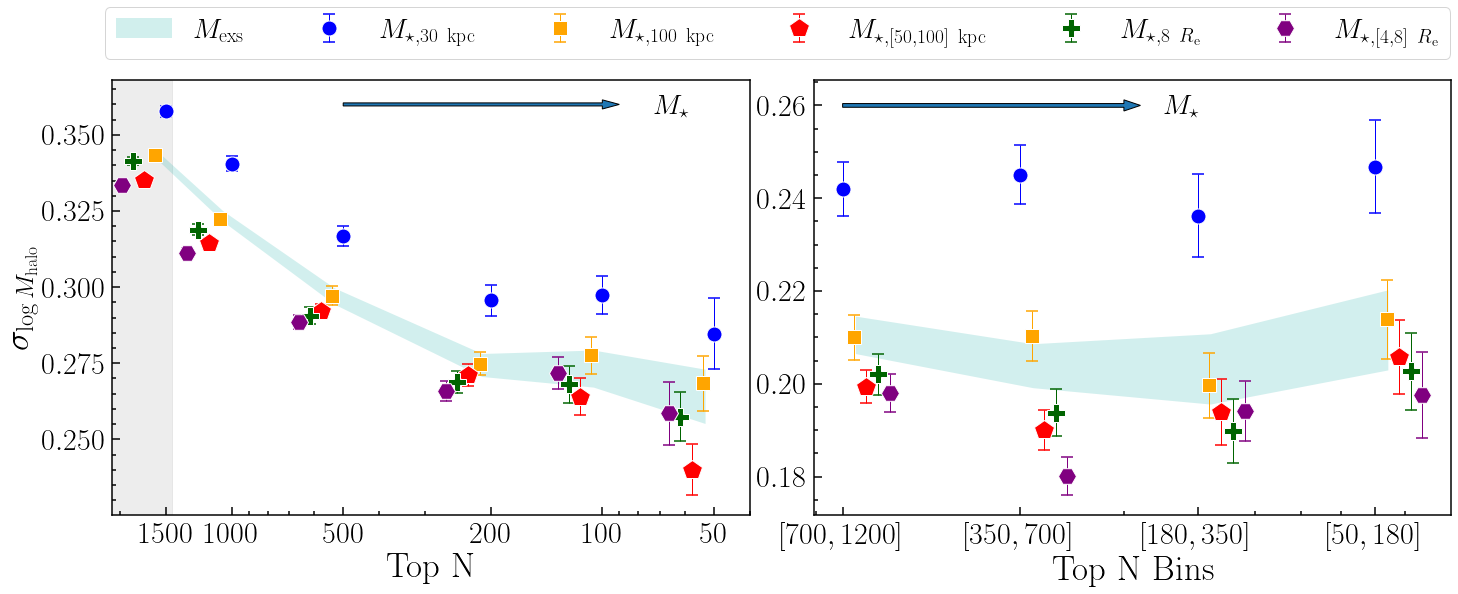

In [14]:
numb_list=np.asarray([50,100,200,500,1000,1500])
numb_list2=np.asarray([800,400,200,100])
numblist=[r'$50$',r'$100$',r'$200$',r'$500$',r'$1000$',r'$1500$']
color_list=['blue','orange','red','darkgreen','purple']
numblist2=[r'$[50,180]$',r'$[180,350]$',r'$[350,700]$',r'$[700,1200]$']
namelist=['aper_30_gal','aper_100_gal','out_50_100_gal','aper_8reff_gal','out_4_8reff_gal']
labellist=[r'$M_{\star,30{\rm\ kpc}}$',r'$M_{\star,100{\rm\ kpc}}$',r'$M_{\star,[50,100]{\rm\ kpc}}$',r'$M_{\star,8\ R_{\rm e}}$',r'$M_{\star,[4,8]\ R_{\rm e}}$']
markerlist=['o','s','p','P','H','X','D','v','*','8','>']
sizelist=np.asarray([10,9,14,12,12,9,9,9,9,9,9])*1.5
fig=plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1,2, hspace=0, wspace=0.1)
(ax1,ax2)= gs.subplots(sharex='col')
ax1.axvspan(1450,2100,color='darkgrey',alpha=0.2)
for i in range(len(namelist)):
    col=color_list[i]
    ax1.errorbar(numb_list*2**(i/10),np.asarray(list(topN_tab1[topN_tab1['item']==namelist[i]][0])[1::2]),yerr=np.asarray(list(topN_tab1[topN_tab1['item']==namelist[i]][0])[2::2]),alpha=1,fmt=markerlist[i],markersize=sizelist[i],
                 capsize=6, capthick=1.5,elinewidth=1,c=col,mec='white',label=labellist[i])
    ax2.errorbar(numb_list2*2**(i/15),np.asarray(list(topN_tab2[topN_tab2['item']==namelist[i]][0])[1::2]),yerr=np.asarray(list(topN_tab2[topN_tab2['item']==namelist[i]][0])[2::2]),alpha=1,fmt=markerlist[i],markersize=sizelist[i],
                 capsize=6, capthick=1.5,elinewidth=1,c=col,mec='white',label=labellist[i])
name='mass_stellar_exs'
err=np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[2::2])
ax1.fill_between(numb_list*2**(1.5/20),np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[1::2])+err,np.asarray(list(topN_tab1[topN_tab1['item']==name][0])[1::2])-err,alpha=0.2,color='lightseagreen',label=r'$M_{\rm exs}$',edgecolor=None)
err=np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[2::2])
ax2.fill_between(numb_list2*2**(1.5/20),np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[1::2])+err,np.asarray(list(topN_tab2[topN_tab2['item']==name][0])[1::2])-err,alpha=0.2,color='lightseagreen',label=r'$M_{\rm exs}$',edgecolor=None)
ax1.set_xlabel(r'\rm Top N',fontsize=35)
ax2.set_xlabel(r'\rm Top N Bins',fontsize=35)
ax1.set_ylabel(r'$\sigma_{\log{M_{\rm halo}}}$',fontsize=35)

ax1.set_xlim(40,2100)
ax1.invert_xaxis()
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xticks(numb_list,numblist)
ax2.set_xticks(numb_list2,numblist2)

ax1.legend(fontsize=28,ncol=6,bbox_to_anchor =(2.12, 1.2))
ax1.arrow(500,0.36,-400,0,head_length=10,width=0.001)
ax1.text(0.85,0.92,r'$M_\star$',transform=ax1.transAxes, size=28)
ax2.text(0.55,0.92,r'$M_\star$',transform=ax2.transAxes, size=28)
ax2.arrow(100,0.26,200,0,head_length=20,width=0.0008)
plt.savefig(fig_dir+'Fig5.png',dpi=200)

In [18]:
mask1=tab0['proj']=='xy'
tabx=topNselect(tab0[mask1],'mass_halo',50)
np.log10(tabx['mass_halo']/0.6774)

14.278941012889687
14.290654059694361
14.290724557416176
14.294767672280472
14.302135208350073
14.304202285797453
14.31689047389059
14.318935915944055
14.32234611678568
...
14.68294575620343


In [19]:
mask1=tab0['proj']=='xy'
tabx=topNselect(tab0[mask1],'mass_halo',100)
np.log10(tabx['mass_halo']/0.6774)

14.14115272904979
14.142716576505348
14.143803563068353
14.14453917548262
14.145070690942987
14.145574198184738
14.148180369734686
14.1489359390843
14.149390958622329
...
14.68294575620343


In [27]:
mask1=(tab0['proj']=='xy')&(tab0["mass_stellar_exs"]<=10**10.5)
tab0[mask1]

gal_num,proj,catsh_primary,mass_halo,mass_stellar_gal,mass_stellar_ins,mass_stellar_exs,aper_10_ins,aper_10_exs,aper_10_gal,aper_30_ins,aper_30_exs,aper_30_gal,aper_50_ins,aper_50_exs,aper_50_gal,aper_75_ins,aper_75_exs,aper_75_gal,aper_100_ins,aper_100_exs,aper_100_gal,aper_150_ins,aper_150_exs,aper_150_gal,ellipticity,ellipticity_ins,ellipticity_exs,ellipticity_10,ellipticity_ins_10,ellipticity_exs_10,ellipticity_30,ellipticity_ins_30,ellipticity_exs_30,ellipticity_40,ellipticity_ins_40,ellipticity_exs_40,ellipticity_50,ellipticity_ins_50,ellipticity_exs_50,ellipticity_inner_10_20,ellipticity_outer_25_45,r_20_ins,r_20_exs,r_20_gal,r_20_ins_force,r_20_exs_force,r_50_ins,r_50_exs,r_50_gal,r_50_ins_force,r_50_exs_force,r_80_ins,r_80_exs,r_80_gal,r_80_ins_force,r_80_exs_force
int64,str2,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
941,xy,True,18257402343750.0,157300317616.2743,127820083443.81453,29480234172.459812,120957210188.30263,14010695442.189913,134967905630.49255,124083622866.67952,17613503336.714474,141697126203.39398,125438939168.87057,19674096913.14363,145113036082.01422,126210256957.71613,21829915811.52307,148040172769.23917,126835791162.03156,24775378074.245537,151611169236.27707,127562780810.80911,28128136012.461735,155690916823.27087,0.2634725209835088,0.30464173891479607,0.17707566681760628,0.2624685414834171,0.31000661325198703,0.24673320681705643,0.26347091259036304,0.3046499970787617,0.24875006361408766,0.26347198979285796,0.3046444662700473,0.24875223103806726,0.2634726677996001,0.3046409850995006,0.248753595245891,0.2634725209835088,0.2634725209835088,1.0743260439299929,1.9073070838693593,1.183161317701717,1.0913448524291085,2.1302203783196094,2.021267501676882,5.097218586602876,2.2950948561025255,2.0579446038991094,5.587622079106752,3.7221799324642766,53.233303327708406,4.9563272681635375,3.755836708331132,50.84294588309854
1187,xy,True,12785000000000.0,209378798623.3942,205974568311.80524,3404230311.5887713,185860998134.84326,541739895.1588972,186402738030.00214,204194945311.98392,740397138.0237186,204935342450.00766,205065497012.59885,1130682888.8594418,206196179901.4583,205664456780.3948,1659048167.4231899,207323504947.818,205803650481.26566,2036875076.8498492,207840525558.11548,205905707158.09305,2775380313.3670096,208681087471.46008,0.2832787525505887,0.2823736659798897,0.5841806853371879,0.3036261879639807,0.30275533958533585,0.5841937392550486,0.18063215006337222,0.18218006050593802,0.5841807319181231,0.18069524217794064,0.1822422105375136,0.5841806341734825,0.18073495326221564,0.18228132866120428,0.5841806924594126,0.20942545408458785,0.18072635419407918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1567,xy,True,11773925781250.0,165630708160.28094,145038000729.5895,20592707430.691277,134694658247.91684,1126365550.7789464,135821023798.69579,138939708348.85538,4950731503.889021,143890439852.74445,141162336119.453,8485245745.822962,149647581865.276,142664209419.98837,12904958390.69011,155569167810.67847,143415959739.20383,15598597813.351368,159014557552.55518,144555606411.3269,18861997833.92589,163417604245.25278,0.1090877904614614,0.09919435070474478,0.7449638398634806,0.09423877538556456,0.06766290456733057,0.7524495911024115,0.0966245039320651,0.06710887171749515,0.7449767500346035,0.09662900510912556,0.06710801336001555,0.7449659805080608,0.09662910486258414,0.06710784146652547,0.7449630377616397,0.09662895542379611,0.09662895542379611,0.9337730963924532,32.5976109522213,1.0355388896093995,0.9590141947264972,27.004130007529238,1.6748760794495587,74.2993741960567,1.9192532277234864,1.7225661392718952,5

In [26]:
len(tab0)/3

2713.0

In [35]:
tab_100=dd.io.load(data_dir+'galaxies_illustris_108_correct.hdf5','/physical_mass')

In [61]:
mask0=(tab_100['catsh_primary']==True)&(tab_100['proj']=='xy')
mask1=(tab_100['catsh_primary']==True)&(tab_100['proj']=='xy')&(tab_100["mass_stellar_exs"]>10**10.5)
tab_100[mask1]

gal_num,proj,catsh_primary,mass_halo,mass_stellar_gal,mass_stellar_ins,mass_stellar_exs,aper_10_ins,aper_10_exs,aper_10_gal,aper_30_ins,aper_30_exs,aper_30_gal,aper_50_ins,aper_50_exs,aper_50_gal,aper_75_ins,aper_75_exs,aper_75_gal,aper_100_ins,aper_100_exs,aper_100_gal,aper_150_ins,aper_150_exs,aper_150_gal,ellipticity,ellipticity_ins,ellipticity_exs,ellipticity_10,ellipticity_ins_10,ellipticity_exs_10,ellipticity_30,ellipticity_ins_30,ellipticity_exs_30,ellipticity_40,ellipticity_ins_40,ellipticity_exs_40,ellipticity_50,ellipticity_ins_50,ellipticity_exs_50,ellipticity_inner_10_20,ellipticity_outer_25_45,r_20_ins,r_20_exs,r_20_gal,r_20_ins_force,r_20_exs_force,r_50_ins,r_50_exs,r_50_gal,r_50_ins_force,r_50_exs_force,r_80_ins,r_80_exs,r_80_gal,r_80_ins_force,r_80_exs_force
int64,str2,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,xy,True,127510947265625.0,2066190376043.6265,560686390562.5717,1505503985481.056,207555627036.31488,311410076235.10693,518965703271.4219,332995744727.9463,650475591743.5587,983471336471.5051,394779222382.93054,837603620637.4735,1232382843020.404,446410616540.2208,997610374458.4845,1444020990998.7053,482440025275.73016,1134225452994.5535,1616665478270.2837,524339935571.7939,1324561069021.4067,1848901004593.2004,0.32051579020551424,0.38182305138178424,0.26912022002313535,0.11887833954263763,0.28828927791392495,0.08399582714352186,0.2422404035479222,0.17523937245971777,0.26441841674823563,0.2890390255324931,0.20480825910004063,0.31436413925876283,0.3150809312061456,0.2307518664325393,0.34708777838795907,0.07845638067499065,0.2706602653122911,4.453013677994293,8.312433919362359,6.726747199500424,4.259572961040245,8.503696538956616,17.577347548100676,31.36501742439625,27.367585055347366,17.101920678317047,31.806234026912538,65.60281752946415,89.78408526046293,84.63300563775309,64.2237801279608,90.75981199295953
1,xy,True,93507939453125.0,1235169258206.9316,556071923603.4055,679097334603.5269,369216859356.50446,210129179768.8653,579346039125.3698,473757634040.2395,338801598725.0923,812559232765.3318,505765270198.9714,411871357346.4621,917636627545.4336,525920694648.90137,482066162552.86633,1007986857201.7676,538402877422.7506,543190619298.0585,1081593496720.8092,551798491796.8573,639687181523.5854,1191485673320.4429,0.10863314899063944,0.11009228902953325,0.0702957797716053,0.0067105923872130884,0.013293878934174242,0.019469369665330482,0.16396914957829994,0.10189593136950216,0.19202648846100648,0.2162155712836295,0.16036349274904776,0.2573037484067997,0.263913477740148,0.1950391640618491,0.30961843296944036,0.021808238282370062,0.19589326792907621,1.4237941599803172,3.59431616370641,1.9333722507142512,1.423988865554457,3.6495817288012797,3.7873164968229434,25.963379248666552,10.91781552611344,3.7923289369453834,26.053057824980755,20.788365250915223,86.81995930073671,59.24956251644049,20.719779898682233,87.04856198106015
2,xy,True,84745781250000.0,1592313759830.1511,463234038381.86676,1129079721448.2852,242072921626.70032,209773863137.59396,451846784764.2943,358105760592.8236,442508698757.0235,800614459349.847,396644465803.7811,582627190271.2714,979271656075.0525,418158607057.1413,713297715640.5839,1131456322697.7253,430340356493.6356,823740446290.9926,1254080802784.6282,450482030432.0332,1027921614871.7004,1478403645303.7336,0.3582466745834194,0.3212663270926454,0.42350971256188774,0.2949143555486013,0.23152376231170194,0.3551057378785537,0.1819642068876369,0.13138121831533828,0.21132193387817808,0.22554900577581313,0.17824840561146724,0.24252098682545314,0.3135327783378968,0.25519837926590055,0.34323303855767784,0.25083

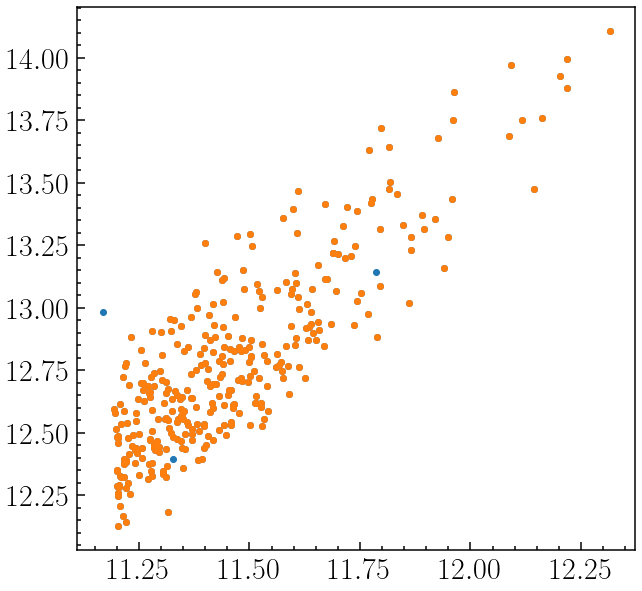

In [56]:
fig=plt.figure(figsize=(10, 10))
plt.scatter(np.log10(tab_100[mask0]["mass_stellar_gal"]),np.log10(tab_100[mask0]["mass_halo"]))
plt.scatter(np.log10(tab_100[mask1]["mass_stellar_gal"]),np.log10(tab_100[mask1]["mass_halo"]))

In [51]:
medNselect(tab0,'aper_30_gal',700,1200)

gal_num,proj,catsh_primary,mass_halo,mass_stellar_gal,mass_stellar_ins,mass_stellar_exs,aper_10_ins,aper_10_exs,aper_10_gal,aper_30_ins,aper_30_exs,aper_30_gal,aper_50_ins,aper_50_exs,aper_50_gal,aper_75_ins,aper_75_exs,aper_75_gal,aper_100_ins,aper_100_exs,aper_100_gal,aper_150_ins,aper_150_exs,aper_150_gal,ellipticity,ellipticity_ins,ellipticity_exs,ellipticity_10,ellipticity_ins_10,ellipticity_exs_10,ellipticity_30,ellipticity_ins_30,ellipticity_exs_30,ellipticity_40,ellipticity_ins_40,ellipticity_exs_40,ellipticity_50,ellipticity_ins_50,ellipticity_exs_50,ellipticity_inner_10_20,ellipticity_outer_25_45,r_20_ins,r_20_exs,r_20_gal,r_20_ins_force,r_20_exs_force,r_50_ins,r_50_exs,r_50_gal,r_50_ins_force,r_50_exs_force,r_80_ins,r_80_exs,r_80_gal,r_80_ins_force,r_80_exs_force
int64,str2,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
845,yz,True,26108173828125.0,457945533914.252,123398136832.1879,334547397082.0639,82637731396.11823,79186369535.27362,161824100931.39185,99678065883.65134,182236993613.17926,281915059496.83057,107988121505.61877,234435877441.9875,342423998947.6062,114458587654.30634,270694077158.53772,385152664812.844,117723292831.03555,296681673474.615,414404966305.65063,121725279241.18835,323372849583.35455,445098128824.54285,0.2839170008300892,0.10334298687229429,0.3416609017336912,0.2576155773622079,0.10490347192019014,0.32509620841395803,0.2626319031687312,0.10334548679729771,0.2778178557647998,0.3336517618519284,0.10334381250177005,0.2635047046054714,0.3285351877679229,0.10334275867608593,0.3758671031012322,0.30362060438540966,0.2953363923904847,1.4434527406375532,8.289061882521182,3.9807954173674736,1.58092815205632,8.054695835037812,3.5407425451834347,25.333332512936533,17.837256667783617,3.8831693180599234,24.506175958626184,22.04110755928283,65.82959537337297,56.235341313048366,24.719051171144933,64.53522455609924
216,yz,True,69767641601562.5,540431868096.4092,131375094697.34105,409056773399.06824,36815857141.713974,91565342009.86389,128381199151.57785,69968052313.4396,211979442782.73254,281947495096.1721,91581822895.0923,278549550468.2427,370131373363.335,108209276205.30797,325722448554.56854,433931724759.8764,117716158440.22429,352935323298.73456,470651481738.95886,126373718976.77473,384175282247.97363,510549001224.74835,0.48605662608549965,0.26252356753494854,0.5480279355907478,0.4834613960384547,0.3165435170672469,0.5802793211554012,0.4457235929491934,0.3154983333962911,0.49858537335098035,0.4821704725358924,0.315497210185087,0.5675929907770815,0.49853007189900855,0.31549650321980155,0.5472904995134853,0.47600628013869334,0.4587070121123407,4.181508619804337,8.844225016580452,7.520514955389799,4.949728067277632,8.321982287691005,21.3054739209341,28.421413599228984,26.257503695239507,24.871448416790486,26.388393264555702,54.06475671356922,70.07958549299306,66.32386642340293,62.06076278703081,66.94570532523409
19,xz,True,132303017578125.0,605356155509.6256,130097705770.53934,475258449739.0857,56282079329.682526,77954712486.18494,134236791815.86746,85001439513.43771,197041587449.42767,282043026962.86536,97766070355.73456,269632538755.35107,367398609111.0857,107620446774.69662,334290155253.4913,441910602028.1879,114021327303.7097,375532621300.0088,489553948603.7185,121057498461.27444,420292929540.7823,541350428002.05664,0.6127005648900542,0.43569348024384985,0.7051316519835226,0.6348619982776955,0.39332764235201234,0.7400953081129982,0.5837200681707299,0.41649466017953685,0.6506102925958555,0.598711172168443,0.4162076254070535,0.6142719781911636,0.5840694300704313,0.4160269615932328,0.5975873171833623,0.6154667056374187,0.59

In [60]:
mask0=(tab0['catsh_primary']==True)&(tab0['proj']=='xy')&(tab0["mass_stellar_ins"]>1e10)&(tab0["mass_stellar_exs"]>10**10.5)
mockmedNscatter(tab0[mask0],'aper_30_gal',700,1200)

aper_30_gal


(0.24185288307534816, 0.005702026028920327)

In [59]:
tab0

gal_num,proj,catsh_primary,mass_halo,mass_stellar_gal,mass_stellar_ins,mass_stellar_exs,aper_10_ins,aper_10_exs,aper_10_gal,aper_30_ins,aper_30_exs,aper_30_gal,aper_50_ins,aper_50_exs,aper_50_gal,aper_75_ins,aper_75_exs,aper_75_gal,aper_100_ins,aper_100_exs,aper_100_gal,aper_150_ins,aper_150_exs,aper_150_gal,ellipticity,ellipticity_ins,ellipticity_exs,ellipticity_10,ellipticity_ins_10,ellipticity_exs_10,ellipticity_30,ellipticity_ins_30,ellipticity_exs_30,ellipticity_40,ellipticity_ins_40,ellipticity_exs_40,ellipticity_50,ellipticity_ins_50,ellipticity_exs_50,ellipticity_inner_10_20,ellipticity_outer_25_45,r_20_ins,r_20_exs,r_20_gal,r_20_ins_force,r_20_exs_force,r_50_ins,r_50_exs,r_50_gal,r_50_ins_force,r_50_exs_force,r_80_ins,r_80_exs,r_80_gal,r_80_ins_force,r_80_exs_force
int64,str2,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,xy,True,935112968750000.0,2313185432742.945,549864876039.7438,1763320556703.1973,404690512431.0753,223654389602.89172,628344902033.967,440338918542.85034,568717072722.4716,1009055991265.3218,468874151795.55176,832466039981.8787,1301340191777.4307,493874279516.0003,1096780434327.9924,1590654713843.9927,511833532702.85156,1298421251291.8547,1810254783994.706,538193275698.2584,1609088412681.063,2147281688379.3215,0.1777548483871337,0.1367780168298721,0.21975332435735467,0.15635283058112057,0.1587838774526987,0.17092878660813188,0.2256462340905731,0.16742746946622497,0.29871546020885975,0.2255702611760019,0.1674362081724456,0.25401511042237424,0.22552244273095862,0.16744170843981743,0.35096316384272436,0.19442276914942905,0.22553279737310997,1.2622715144791077,14.374861527387306,4.007050880856718,1.3239098245052017,14.39050025592999,2.397404426369568,47.35019947691138,33.15902534657987,2.5180360315792045,47.10189589586956,26.23764152601251,102.29158441820957,91.79575626280356,24.920546845454453,102.02588646583627
0,yz,True,935112968750000.0,2440303566430.2744,556775179977.3944,1883528386452.8787,404724099592.62225,222140096317.977,626864195910.5991,442749776448.63116,593042996773.8513,1035792773222.4824,473626917194.5193,881049877037.2109,1354676794231.73,499838534568.2673,1182937020445.277,1682775555013.5444,519292182583.1614,1409976317183.2312,1929268499766.3923,545566828795.9614,1731783330685.0046,2277350159480.9663,0.23429547598923106,0.14631986332793862,0.24582442115313738,0.20590185303342579,0.1562383624011771,0.22702475282911605,0.296448398058407,0.17904818061649486,0.3052657177873979,0.3462858717137801,0.1791731059737984,0.34129789935097304,0.4077508605165376,0.17925173579031203,0.4042203734020265,0.18530051782356902,0.3175204148053509,1.3026888528749518,15.15916226273354,5.047754096395951,1.3591569826712981,15.104183723094211,2.5563879031697807,47.02613844969209,35.12216322820332,2.635649405056044,47.27399867710854,26.658225806067094,97.43455109079586,89.34404801963356,29.496117725543133,98.07381700761552
0,xz,True,935112968750000.0,2602477311365.8516,558650090107.518,2043827221258.329,406258320702.8622,255622004520.40875,661880325223.2709,447061509418.23474,692957511361.3462,1140019020779.581,478999852968.8766,1001493397610.7654,1480493250579.642,505061751184.77826,1300256075515.7812,1805317826700.5596,524045723629.4966,1536757570196.4224,2060803293825.919,548932038710.9195,1864333311799.9106,2413265350510.83,0.15485156791074636,0.11703953459079659,0.17597997395191117,0.11431070543136296,0.15566383551078516,0.146329135797698,0.24794442344618628,0.0581076537841482,0.3088281298562693,0.2820148432749331,0.057945034329644866,0.25383876160277646,0.2646907146722486,0.05784267930625226,0.25402718918991796,0.110977227

(array([ 17.,  45., 188., 335., 458., 412., 331., 150.,  47.,  17.]),
 array([-0.13050071, -0.10400267, -0.07750462, -0.05100658, -0.02450854,
         0.00198951,  0.02848755,  0.0549856 ,  0.08148364,  0.10798168,
         0.13447973]),
 <BarContainer object of 10 artists>)

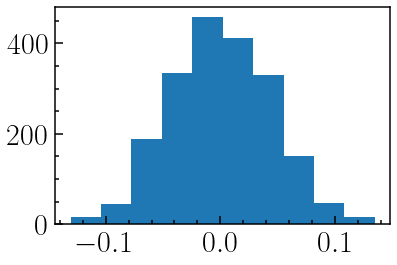

In [72]:
plt.hist(np.log10(np.random.lognormal(sigma=0.1,size=2000)))